<a id="top"></a>

# Extracting and Analyzing experimental metadata from Gene Expression Omnibus (GEO)

## **Table of Contents**

1. [Introduction](#1.-Introduction)
2. [Setting Up the Environment](#2.-Setting-up-the-environment)
3. [Data Extraction from GEO](#3.-Data-extraction-from-GEO)
4. [Labeling data with LLama3.2 via Ollama](#4.-Labeling-data-with-LLama3.2-via-Ollama)
5. [Download data](#5.-Download-data)
6. [Conclusions](#6.-Conclusions)

## 1. Introduction

This notebook demonstrates an automated approach to **identifying** and **acquiring** specific types of publicly available genomic data. We focus on **single-cell transcriptomic data** generated from **biological fluids**, particularly **whole blood** or **peripheral blood mononuclear cells (PBMCs)**. This notebook will touch on of two topics:

- Programmatic Extraction of study metadata
- AI-Driven Analysis of Experimental Metadata

### 1.1 Programmatic Extraction of Study metadata

Public repositories like the Gene Expression Omnibus (GEO) contain vast amounts of valuable OMICS datasets. However, manually searching can be time-consuming and error-prone. In this notebook, we will utilize: 

- Python libraries to interact with the GEO database
- Automated querying based on specific search criteria
- Downloading of relevant dataset metadata and supplementary files

This programmatic approach allows us to:

- Rapidly scan through thousands of datasets
- Apply consistent criteria across all searches
- Automate the retrieval process, saving time and reducing human error

### 1.2 AI-Driven Analysis of Experimental Metadata

While we can efficiently extract data from GEO, we face a significant challenge: the **lack of standardization in experimental metadata**. Researchers often describe their experiments using varied terminology, levels of detail, and structures. This is where artificial intelligence (AI) becomes invaluable. Our AI-driven analysis:

- Interprets and standardizes varied descriptions into consistent categories

By combining programmatic data extraction with AI-driven metadata analysis, we can:

- More accurately identify relevant datasets
- Reduce the time and effort required for manual review
- Scale our analysis to handle the growing number of publicly available datasets
- Make better-informed decisions on dataset selection for further analysis

This integrated approach allows us to efficiently navigate vast public databases and identify datasets that can serve as a foundation for developing targeted biomarker discovery strategies, despite the lack of standardization in the original metadata.

**Note:** This notebook assumes you have Ollama set up and running. For instructions on setting up Ollama, please refer to the [official Ollama documentation](https://ollama.ai/docs).

Let's begin by setting up our environment and importing the necessary libraries.

[Back to Top](#top)

## 2. Setting up the environment

### 2.1 - Libraries

In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq ollama==0.3.3 --progress-bar off

In [1]:
from datetime import datetime, timedelta, date
from Bio import Entrez
import pandas as pd
import GEOparse
import re
from IPython.display import display, Markdown, Latex
import time
import os
import numpy as np
import re
import logging

import json
from enum import Enum
from pathlib import Path
 
import ollama
from IPython.display import Image, Markdown, display
from tqdm import tqdm
import urllib.request

import matplotlib.pyplot as plt
import seaborn as sns

In [244]:
from IPython.display import HTML, display

back_to_top_button = """
<script>
    function scrollToTop() {
        document.querySelector('.jp-Notebook').scrollTop = 0;
    }
</script>

<button onclick="scrollToTop()" 
        style="
            position: fixed;
            bottom: 20px;
            right: 20px;
            z-index: 99;
            font-size: 14px;
            border: none;
            outline: none;
            background-color: #0066cc;
            color: white;
            cursor: pointer;
            padding: 10px;
            border-radius: 4px;">
    Back to Top
</but
"""

### 2.2 - Functions

#### 2.2.1 - Data Mining from Gene Expression Omnibus (GEO)

In [ ]:
def fetch_gse_ids(disease, organism, technology=None, biological_fluid=None, email="YOUR_EMAIL", data_type="GSE[ETYP]"):
    """
    Fetch GSE IDs based on the disease variants, organism, technology, biological fluid, and data type.
    
    Parameters:
    - disease: List of disease variants to be queried (e.g., ["Parkinson disease", "Parkinson's disease"]).
    - organism: Organism to be queried.
    - technology: List of technologies to be queried (e.g., ["scRNA-seq", "single-cell"]). Default is None.
    - biological_fluid: List of biological fluids to be queried (e.g., ["Blood", "PBMCs"]). Default is None.
    - email: Email to be used with Entrez. Default is "f.nunez.villena@gmail.com".
    - data_type: Type of data. Default is "GSE[ETYP]".
    
    Returns:
    - List of GSE IDs.
    """
    # Setting the email for Entrez
    Entrez.email = email
    
    # Creating the base query
    disease_query = ' OR '.join([f'({variant}[All Fields] OR "{variant}"[All Fields])' for variant in disease])
    query = f'({disease_query}) AND {organism}[Organism]'
    
    # Add technology to the query if provided
    if technology:
        tech_query = ' OR '.join([f'({tech}[All Fields] OR "{tech}"[All Fields])' for tech in technology])
        query += f' AND ({tech_query})'
    
    # Add biological fluid to the query if provided
    if biological_fluid:
        if isinstance(biological_fluid, list):
            fluid_query = ' OR '.join([f'({fluid}[All Fields] OR "{fluid}"[All Fields])' for fluid in biological_fluid])
            query += f' AND ({fluid_query})'
        else:
            query += f' AND ({biological_fluid}[All Fields] OR "{biological_fluid}"[All Fields])'
    
    # Add data type, but make it optional
    query += f' AND ({data_type} OR GDS[ETYP])'
    
    # Print the final query
    print(f"Executing query: {query}")
    
    try:
        handle = Entrez.esearch(db="gds", 
                                term=query, 
                                retmax=3000000, 
                                usehistory=True)
        result = Entrez.read(handle)
        handle.close()
    except Exception as e:
        print(f"Error fetching data: {e}")
        return []
    return transform_ids_to_gse(result['IdList'])

def transform_ids_to_gse(id_list):
    """
    Transform the fetched IDs into GSE IDs.
    
    Parameters:
    - id_list: List of IDs to be transformed.
    
    Returns:
    - List of GSE IDs.
    """
    uid_regex = re.compile('[1-9]+0+([1-9]+[0-9]*)')
    
    try:
        gse_list = ['GSE' + uid_regex.match(uid).group(1) for uid in id_list]
        return gse_list
    except Exception as e:
        print(f"Error transforming IDs: {e}")
        return []

# Function to download a file
def download_file(url, dest_folder):
    filename = os.path.basename(url)
    filepath = os.path.join(dest_folder, filename)
    print(f"Downloading: {filename}")
    urllib.request.urlretrieve(url, filepath)
    print(f"Downloaded: {filename}")

#### 2.2.2 - Functions to structure output from Ollama

In [181]:
class ResponseFormat(Enum):
    JSON = "json_object"
    TEXT = "text"
 
def call_model(
    prompt: str, response_format: ResponseFormat = ResponseFormat.TEXT
) -> str:
    response = ollama.generate(
        model=MODEL,
        prompt=prompt,
        keep_alive="1h",
        format="" if response_format == ResponseFormat.TEXT else "json",
        options={"temperature": TEMPERATURE},
    )
    return response["response"]

def create_classify_prompt(text: str) -> str:
    return CLASSIFY_TEXT_PROMPT.format(text=text)

## 3. Data extraction from GEO

This section focuses on extracting and organizing metadata from Gene Expression Omnibus (GEO) datasets. The process involves several key steps:

Fetching GSE IDs: We use the Bio.Entrez module to query GEO and retrieve relevant GSE (GEO Series) IDs based on our specified criteria, such as disease type, organism, and technology.
Downloading SOFT Files: For each GSE ID, we download the corresponding SOFT (Simple Omnibus Format in Text) file. These files contain detailed metadata about each study.
Extracting Metadata: We then parse these SOFT files to extract key information. This includes:

Basic study details (title, accession number, submission date)
Study design and summary
Sample information (organism, characteristics)
Experimental details (library strategy, technology used)


Organizing into a DataFrame: All extracted information is compiled into a pandas DataFrame for easy manipulation and analysis. Each row in this DataFrame represents a unique study, with columns for different metadata fields.

[Back to Top](#top)

### 3.1. Fetching GSE IDs

In [140]:
# Getting the current working directory
current_dir = os.getcwd()

# Path to the download directory
download_dir = os.path.join(current_dir, "Disease_Test")

# Creating the directory if it doesn't exist
os.makedirs(download_dir, exist_ok=True)

gse_ids = fetch_gse_ids(
    disease=["Parkinson disease", "Parkinson's disease"],
    organism="homo sapiens",
    technology=["scrna-seq", "scrnaseq", "single-cell", "single cell"],
    biological_fluid= ["blood", "pbmc", "peripheral blood mononuclear cells"]
)

### 3.2. Downloading SOFT Files

In [6]:
# Setting up logging
logging.basicConfig(level=logging.WARNING)  # This will suppress INFO and DEBUG messages
geo_logger = logging.getLogger('GEOparse')
geo_logger.setLevel(logging.WARNING)  # This will suppress INFO and DEBUG messages for GEOparse

for idx, gse in enumerate(gse_ids, start=1):
    try:
        GEOparse.get_GEO_file(gse, silent=True, destdir = download_dir)
        logging.info(f"The study {gse} has been downloaded ... {idx} studies downloaded.")
    except Exception as e:
        logging.warning(f"The study {gse} is not available yet ... {idx} studies downloaded. Error: {e}")

### 3.3. Extracting metadata as a dataframe

This code automates the extraction and organization of metadata from GEO SOFT files, focusing on essential study and sample details. It reads each file, filters key information like study title, accession numbers, and sample characteristics, and compiles the data into a structured format using DataFrames. Missing data is handled gracefully, and a link to each study is generated for easy access. In the end, all processed study information is combined into a single table, with an additional text field that merges the study summary and design for easier review.

[Back to Top](#top)

In [142]:
soft_files = os.listdir(download_dir)
Soft_Paths = [os.path.join(download_dir,soft) for soft in soft_files]

cols_interest = ['title','geo_accession','status','submission_date','pubmed_id','summary','overall_design','type','relation','contact_country',
                 'contact_email','contact_institute']
geo_link = 'https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc='
lst_dfs = []

for file in Soft_Paths:
    gse_lst = [] # It should contain a list of dictionaries 
    try:
       # 1 - GET ARTICLE METADATA
       # 1.1 - Read SOFT files
        gse = GEOparse.get_GEO(filepath = file,silent=True,destdir= None)
        filtered_dictionary = {}
       # 1.2 - Evaluating sample_id presence
        if 'sample_id' in gse.metadata.keys():
            filtered_dictionary['Number_of_samples'] = len(gse.metadata['sample_id'])
        else:
            filtered_dictionary['sample_id'] = "sample_id not available"
            filtered_dictionary['Number_of_samples'] = 0
            
        # 1.3 - Evaluating cols_interest
        for x, y in gse.metadata.items():
            if x in cols_interest:
                filtered_dictionary[x] = y[0]

        # 1.4 - Adding a link to the study
        filtered_dictionary['link_to_study'] = geo_link + gse.metadata['geo_accession'][0]
        
        # 2   - GET SAMPLE METADATA
        # 2.1 - ADDING INFO WHEN PHENOTYPE_DATA IS EMPTY
        if gse.phenotype_data.empty:
            filtered_dictionary['Organism'] = 'No organism info in sample metadata'
            filtered_dictionary['Sample_characteristics'] = 'No sample info in sample metadata'
            filtered_dictionary['Library_strategy'] = 'No library info in sample metadata'
        
        # 2.2   - ADDING INFO WHEN PHENOTYPE_DATA IS NOT EMPTY
        # 2.2.1 - Organism information
        else:
            if len(gse.phenotype_data['organism_ch1'].unique()) == 1:
                filtered_dictionary['Organism'] = ''.join(gse.phenotype_data['organism_ch1'].unique())
            else:
                filtered_dictionary['Organism'] = ', '.join(gse.phenotype_data['organism_ch1'].unique())
               
 
            # 3 - Obtaining Sample information: All available sample information is stored as a dictionary
        
            sample_dict = {}
            for column in gse.phenotype_data.filter(like='characteristics').columns:
                sample_dict[column] = gse.phenotype_data[column].unique()

            filtered_dictionary['Sample_characteristics'] = sample_dict
        
             # 4 - Obtaining library strategy: All available sample information is stored as a dictionary
            
            if 'library_strategy' in gse.phenotype_data.columns:
                filtered_dictionary['Library_strategy'] = gse.phenotype_data['library_strategy'].unique()
            else:
                 filtered_dictionary['Library_strategy'] = "No library info in sample metadata"
                
    except OSError:
        #print("The study has not been processed")
        continue
    gse_lst.append(filtered_dictionary)
    GSE_studies = pd.DataFrame(gse_lst)
    lst_dfs.append(GSE_studies)
    #print("The study {} has been processed".format(gse))
    
df = pd.concat(lst_dfs)
df.reset_index(drop=True, inplace = True)
df['merged_text'] = df['summary'] + df['overall_design']

Our output contains the following key features:

1. **geo_accession:** Unique identifier for each GEO series.
2. **title:** The title of the study, providing a quick overview of its focus.
3. **status:** Current status of the dataset (e.g., public, private).
4. **submission_date:** When the study was submitted to GEO.
5. **pubmed_id:** Associated PubMed ID for related publications.
6. **summary:** Brief description of the study's objectives and methods.
7. **overall_design:** Explanation of the experiment.
8. **type:** The type of data/experiment conducted.
9. **contact_email:** Email of the primary contact for the study.
10. **contact_institute:** Institution associated with the study.
11. **contact_country:** Country where the research was conducted.
12. **relation:** Links to related datasets or resources.
13. **link_to_study:** Direct URL to the GEO entry.
14. **Organism:** The species studied.
15. **Sample_characteristics:** Detailed information about the biological samples used.
16. **Library_strategy:** The sequencing strategy employed.
17. **Number_of_samples:** Total number of samples in the study.
18. **merged_text:** Combined summary and overall design for easier text analysis.

[Back to Top](#top)

In [146]:
display(df.head())

,Number_of_samples,title,geo_accession,status,submission_date,pubmed_id,summary,overall_design,type,contact_email,contact_institute,contact_country,relation,link_to_study,Organism,Sample_characteristics,Library_strategy,merged_text
0,6,Single-cell RNA sequencing reveals peripheral ...,GSE223138,Public on Oct 09 2024,Jan 18 2023,39366969,Parkinson's disease (PD) is a neurodegenerativ...,"In this study, we presented 5 major immune cel...",Expression profiling by high throughput sequen...,"775886450@qq.com, liulin.xiong@mymail.unisa.ed...",Sichuan University West China Hospital,China,BioProject: https://www.ncbi.nlm.nih.gov/biopr...,https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi...,Homo sapiens,{'characteristics_ch1.0.disease state': ['Norm...,[RNA-Seq],Parkinson's disease (PD) is a neurodegenerativ...
1,8,Early-to-mid stage idiopathic Parkinson’s dise...,GSE237254,Public on Oct 13 2023,Jul 13 2023,37985656,Neuroinflammation in the brain contributes to ...,We compared samples between patients with earl...,Expression profiling by high throughput sequen...,feng.he@lih.lu,Luxembourg Institute of Health,Luxembourg,BioProject: https://www.ncbi.nlm.nih.gov/biopr...,https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi...,Homo sapiens,"{'characteristics_ch1.0.tissue': ['PBMC'], 'ch...",[RNA-Seq],Neuroinflammation in the brain contributes to ...
2,12,Gene expression of A53T and corrected IPSC dri...,GSE46798,Public on Dec 05 2013,May 09 2013,24290359,Parkinson disease (PD) is characterized by ext...,"In the current study, isogenic hiPSCs differin...",Expression profiling by array,ryan.scottd@gmail.com,University of Guelph,Canada,BioProject: https://www.ncbi.nlm.nih.gov/biopr...,https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi...,Homo sapiens,{'characteristics_ch1.0.cell type': ['DA neuro...,No library info in sample metadata,Parkinson disease (PD) is characterized by ext...
3,7,Human induced pluripotent stem cell-derived ma...,GSE93285,Public on Jan 07 2017,Jan 06 2017,28111278,"Tissue-resident macrophages such as microglia,...",The human hiPSC-AH016-3 has been used for all ...,SNP genotyping by SNP array,julian.buchrieser@gmail.com,Oxford University,United Kingdom,BioProject: https://www.ncbi.nlm.nih.gov/biopr...,https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi...,Homo sapiens,"{'characteristics_ch1.0.gender': ['male'], 'ch...",No library info in sample metadata,"Tissue-resident macrophages such as microglia,..."
4,35,CD4+ T cells contribute to neurodegeneration i...,GSE141578,Public on Sep 14 2021,Dec 06 2019,34648304,Recent studies indicate that the adaptive immu...,scRNAseq of CSF cells from healthy (n=11) and ...,Expression profiling by high throughput sequen...,dgate@northwestern.edu,Northwestern University,USA,BioProject: https://www.ncbi.nlm.nih.gov/biopr...,https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi...,Homo sapiens,{'characteristics_ch1.0.tissue': ['cerebrospin...,[RNA-Seq],Recent studies indicate that the adaptive immu...


In [147]:
print(f"Total number of studies: {len(df)}")
print(f"Date range of studies: from {df['submission_date'].min()} to {df['submission_date'].max()}")
print(f"Average number of samples per study: {df['Number_of_samples'].mean():.2f}")
print(f"Most common library strategy: {df['Library_strategy'].mode()[0]}")

# Count studies by country
country_counts = df['contact_country'].value_counts()
print("\nTop 5 countries by number of studies:")
print(country_counts.head())

Total number of studies: 12
Date range of studies: from Dec 06 2019 to Sep 20 2023
Average number of samples per study: 22.08
Most common library strategy: ['RNA-Seq']

Top 5 countries by number of studies:
USA           4
China         2
Germany       2
Luxembourg    1
Canada        1
Name: contact_country, dtype: int64


## 4. Labeling data with LLama3.2 via Ollama

Despite the experimental data being successfully organized into a structured table, the descriptions and metadata contain a significant amount of textual information. Given the complexity and volume of this text, it makes sense to implement an AI-based approach for further analysis. AI models can help extract key insights, summarize large sections of text, or even categorize the studies based on their metadata. This approach would streamline the process of navigating through the data, allowing for more efficient and meaningful interpretations of the experimental details.

Our primary goal in this analysis is to identify and characterize single-cell RNA sequencing (scRNA-seq) studies focused on Parkinson's disease (PD) using blood or PBMC derived samples. By using Llama 3.2 to analyze and classify GEO datasets, we aim to efficiently identify studies that align with these our biological objectives. We're particularly interested in:

1. Studies using single-cell transcriptomics on whole blood or PBMCs from PD patients and controls.
2. Experiments that might reveal novel cell populations or gene expression patterns associated with PD.
3. Research that combines scRNA-seq of blood samples with clinical data, potentially linking molecular changes to disease phenotypes.

This AI-driven approach allows us to rapidly sift through large amounts of metadata, identifying the most relevant datasets for in-depth analysis. By focusing on these specific types of studies, we hope to contribute to a better understanding of PD's systemic effects and potentially uncover new avenues for biomarker discovery and therapeutic interventions.

[Back to Top](#top)

### 4.1. Setting Up Ollama

In [52]:
! ollama run llama3.2

pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠦ pulling manifest ⠇ pulling manifest ⠇ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠹ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠇ pulling manifest 
pulling dde5aa3fc5ff...   0% ▕                ▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕                ▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕                ▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕                ▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕                ▏ 6.0 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   1% ▕                ▏  12 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   1% ▕         

### 4.2. Creating Classification Prompts

The following code block represents a prompt engineered for classifying biomedical research texts, specifically focusing on single-cell transcriptomics studies. The prompt is designed to extract key information about the **technology** used and the **sample type**, while also providing a **justification** for the classifications.

[Back to Top](#top)

In [218]:
MODEL = "llama3.2"
TEMPERATURE = 0
CLASSIFY_TEXT_PROMPT = """
You are an AI system trained to analyze biomedical research texts. Your task is to analyze the following merged text, which contains both a 
summary and overall design of a study, and perform two types of tasks:
1 - Labeling Tasks: Classify the text based on two criteria.
2 - Text Generation Task: Provide a brief justification for your classifications.

Labeling Tasks:
1. technology:
   Choose one: ['Single-cell transcriptomics', 'Other assay']
   IMPORTANT: Choose 'Single-cell transcriptomics' if the study mentions single-cell RNA sequencing (scRNA-seq) or similar single-cell technologies.

2. sample:
   Choose one: ['Blood', 'PBMC', 'PBMC-sorted cells', 'Other sample']
   IMPORTANT: Follow these guidelines strictly:
   Step 1: Does the text explicitly mention using "peripheral blood mononuclear cells" or "PBMCs"?
   If YES, continue to Step 2. If NO, go to Step 4.
   Step 2: Does the text mention any sorting or isolation of specific cell types BEFORE the single-cell analysis?
   If YES, classify as "PBMC-sorted cells". If NO, continue to Step 3.
   Step 3: If PBMCs were used without prior sorting, classify as "PBMC".
   Step 4: Does the text mention using whole blood samples without any separation?
   If YES, classify as "Blood". If NO, classify as "Other sample".
   
   Examples:
   1. "We profiled peripheral blood mononuclear cells (PBMCs) using scRNA-seq." -> PBMC
   3. "CD4+ T cells were isolated from PBMCs using FACS, then underwent scRNA-seq." -> PBMC-sorted cells
   4. "Whole blood samples were directly used for scRNA-seq." -> Blood
   5. "PBMCs were collected and analyzed by scRNA-seq, revealing distinct T cell and B cell populations." -> PBMC

Text Generation Task:
justification:
Provide a brief explanation (3-4 sentences) for your classifications. Focus on the key elements in both the summary and overall design that led to your decisions for the labeling tasks. Be particularly detailed in explaining your reasoning for the sample classification. Quote specific phrases from the text that support your decision, especially those mentioning the sample type or any cell isolation procedures.

<text>
{text}
</text>

IMPORTANT: Please provide your analysis as a JSON object. Use ONLY the following keys:
technology, sample, justification

Ensure that the values for 'technology' and 'sample' are single string values from the provided options, while 'justification' should be a brief textual
explanation.
"""

### 4.3. Analyzing and Classifying Data

In [219]:
%%time

responses = [
    call_model(create_classify_prompt(text), response_format=ResponseFormat.JSON)
    for text in tqdm(df['merged_text'])
]
 
rows = []

for geo, text, response in zip(df['geo_accession'], df['merged_text'], responses):
    response = json.loads(response)
    rows.append(
        {
            "geo_accession" : geo,
            "text": text,
            "technology": response["technology"],
            "sample": response["sample"],
            "justification": response["justification"],
        }
    )

df_out = pd.DataFrame(rows)






  0%|          | 0/12 [00:00<?, ?it/s]




  8%|▊         | 1/12 [00:43<07:53, 43.02s/it]




 17%|█▋        | 2/12 [01:18<06:22, 38.29s/it]




 25%|██▌       | 3/12 [01:46<05:04, 33.80s/it]




 33%|███▎      | 4/12 [02:23<04:40, 35.05s/it]




 42%|████▏     | 5/12 [02:50<03:44, 32.10s/it]




 50%|█████     | 6/12 [03:06<02:39, 26.60s/it]




 58%|█████▊    | 7/12 [03:47<02:36, 31.34s/it]




 67%|██████▋   | 8/12 [04:26<02:15, 33.88s/it]




 75%|███████▌  | 9/12 [04:56<01:37, 32.60s/it]




 83%|████████▎ | 10/12 [05:28<01:04, 32.40s/it]




 92%|█████████▏| 11/12 [06:13<00:36, 36.28s/it]




100%|██████████| 12/12 [07:06<00:00, 35.51s/it]

CPU times: user 211 ms, sys: 42.7 ms, total: 254 ms
Wall time: 7min 6s


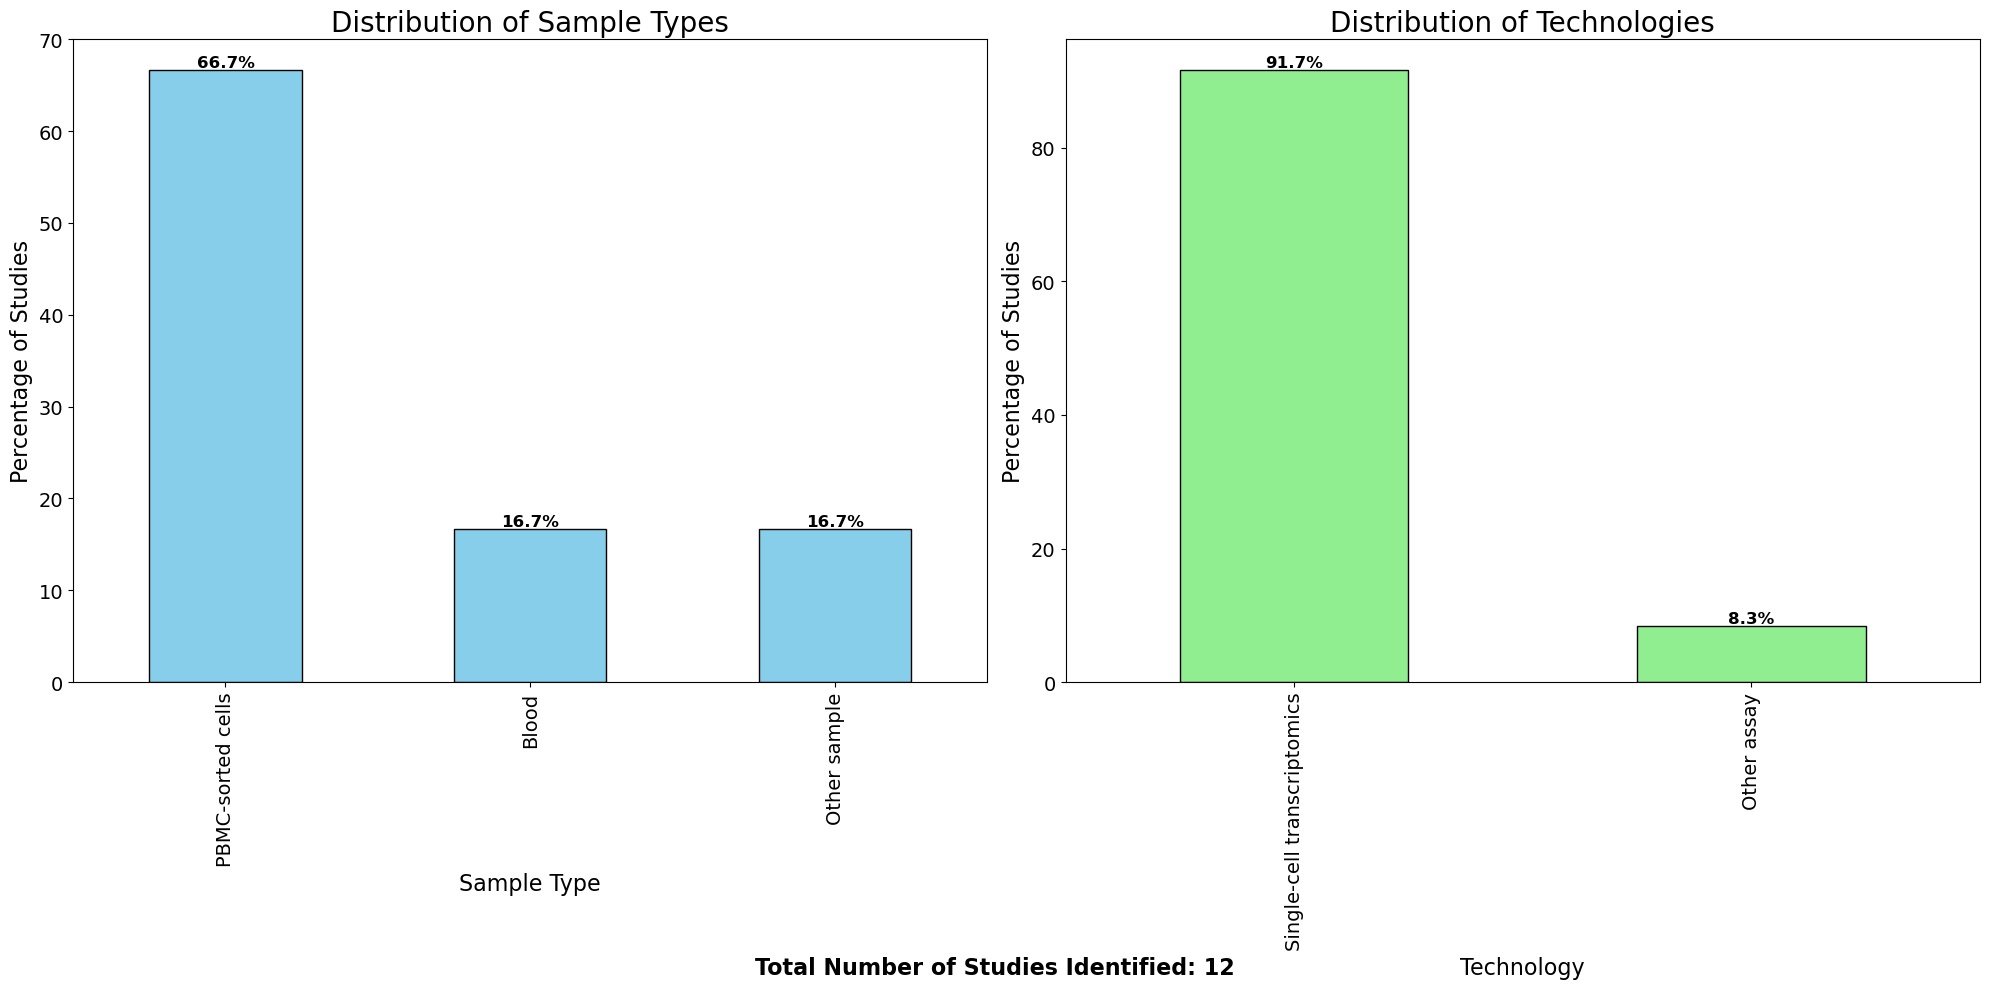

Sample Type Distribution:
PBMC-sorted cells    8
Blood                2
Other sample         2
Name: sample, dtype: int64

Technology Distribution:
Single-cell transcriptomics    11
Other assay                     1
Name: technology, dtype: int64


In [233]:
# Get value counts for 'sample' and 'technology'
sample_counts = df_out['sample'].value_counts()
technology_counts = df_out['technology'].value_counts()

# Calculate percentages
sample_percentages = sample_counts / len(df_out) * 100
technology_percentages = technology_counts / len(df_out) * 100

# Create a figure with three subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot for sample types
sample_percentages.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Sample Types', fontsize=20)
ax1.set_xlabel('Sample Type', fontsize=16)
ax1.set_ylabel('Percentage of Studies', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
for i, v in enumerate(sample_percentages):
    ax1.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Plot for technologies
technology_percentages.plot(kind='bar', ax=ax2, color='lightgreen', edgecolor='black')
ax2.set_title('Distribution of Technologies', fontsize=20)
ax2.set_xlabel('Technology', fontsize=16)
ax2.set_ylabel('Percentage of Studies', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)
for i, v in enumerate(technology_percentages):
    ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()

# Add text for total number of studies
total_studies = len(df_out)
fig.text(0.5, 0.02, f'Total Number of Studies Identified: {total_studies}', ha='center', fontsize=16, fontweight='bold')

plt.show()

# Print the numerical results
print("Sample Type Distribution:")
print(sample_counts)
print("\nTechnology Distribution:")
print(technology_counts)

Our query results have provided valuable insights into the distribution of transcriptomics studies across different sample types and technologies. This analysis will focus on the key findings and their implications for our research direction.
Key Observations

**Prevalence of Single-Cell Transcriptomics:**

As anticipated, our query returned a high number of single-cell transcriptomics studies.
This aligns with the current trend in the field, where single-cell technologies are increasingly being used for their ability to provide high-resolution insights into cellular heterogeneity.


**Limited Blood Sample Studies:**

Only **2 studies** were returned that used blood samples.
This low number is unexpected, given that blood is often considered an accessible and informative tissue for many types of studies.

In [242]:
df_out[(df_out['sample']=='Blood') & (df_out['technology']=='Single-cell transcriptomics')]

,geo_accession,text,technology,sample,justification
0,GSE223138,Parkinson's disease (PD) is a neurodegenerativ...,Single-cell transcriptomics,Blood,The study uses single-cell RNA sequencing (scR...


In our systematic review of transcriptomics studies, we identified only **one study** that employed **single-cell RNA sequencing** to analyze 
transcriptomes in the context of Parkinson's Disease using **blood-derived samples**. Our initial AI-based classification labeled this study as using "Blood" samples. However, upon careful examination of the full text, we discovered that the study specifically used Peripheral Blood Mononuclear Cells (PBMCs), highlighting despite an important prompt engineering step, the AI still has difficulties of understanding the nuances of the biological text data and suggesting that fine tuning of Llama 3.2 should be made to make a model proficient in AI-based curation tasks

### Study Overview

**Methodology**

Technology: Single-cell RNA sequencing (scRNA-seq)
Sample Type: Peripheral Blood Mononuclear Cells (PBMCs)

**Sample Sizes**

2 early Parkinson's Disease (PD) patients
2 advanced PD patients
2 matched controls


**Enlarged Cohort for Validation:**

14 normal individuals
21 early PD patients
14 advanced PD patients

**Disease Conditions Profiled**

Early-stage Parkinson's Disease
Advanced-stage Parkinson's Disease
Healthy controls

**Key Learnings**

**Scarcity of Studies:** The identification of only one study using single-cell transcriptomics on blood-derived samples in Parkinson's Disease research underscores the novelty of this approach and the potential gap in the current research landscape.

**Sample Type Precision:** Our analysis revealed the importance of distinguishing between whole blood and PBMCs. While our AI initially classified the study as using "Blood" samples, it actually used PBMCs, which represent a specific subset of blood cells.

## 5. Download data

Having identified this valuable study, our next step was to acquire the data for further analysis. We used the Gene Expression Omnibus (GEO) database to access and download the data.

### GEO Dataset Details

**Accession Number**: GSE223138
**Title**: "Single-cell RNA sequencing reveals peripheral immunological responses and cell-specific biomarker in patients with Parkinson's disease"
**Number** of Samples: 6

### Download Process: 

- We accessed the GEO database and located the dataset using its accession number (GSE223138).
- The system identified a supplementary file available for download: GSE223138_RAW.tar
- We initiated the download process, which successfully retrieved the file.
- The downloaded data will be stored in a local folder named **GSE223138_files** for easy access and organization.

[Back to Top](#top)

In [129]:
# Replace 'GSE12345' with your actual GEO accession number
accession_number = 'GSE223138'
working_dir = 'Disease_Test'

# Construct the full path to the SOFT file
soft_file_path = os.path.join(working_dir, f"{accession_number}_family.soft.gz")

# Check if the file exists
if not os.path.exists(soft_file_path):
    print(f"Error: SOFT file for {accession_number} not found in {local_dir}")
    exit(1)

# Parse the local SOFT file
try:
    # Download and parse the GEO dataset
    gse = GEOparse.get_GEO(geo=accession_number, destdir="./")
    print(f"Successfully parsed {accession_number} from local SOFT file")

    # Access dataset information
    print(f"Dataset: {accession_number}")
    print(f"Title: {gse.metadata['title'][0]}")
    print(f"Number of samples: {len(gse.gsms)}")

    # Access the supplementary files
    suppl_files = gse.metadata.get('supplementary_file', [])

    print(f"\nSupplementary files for {accession_number}:")
    for file in suppl_files:
        print(file)

    # Create a directory for downloads
    download_dir = f"{accession_number}_files"
    os.makedirs(download_dir, exist_ok=True)

    # Ask user if they want to download the files
    user_input = input("\nDo you want to download these supplementary files? (yes/no): ").lower()
    if user_input == 'yes':
        # Download each supplementary file
        for file_url in suppl_files:
            download_file(file_url, download_dir)
        print(f"\nAll files have been downloaded to the '{download_dir}' folder.")
    else:
        print("Download skipped.")

except Exception as e:
    print(f"Error parsing SOFT file: {e}")

Successfully parsed GSE223138 from local SOFT file
Dataset: GSE223138
Title: Single-cell RNA sequencing reveals peripheral immunological responses and cell-specific biomarker in patients with Parkinson’s disease
Number of samples: 6

Supplementary files for GSE223138:
ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE223nnn/GSE223138/suppl/GSE223138_RAW.tar



Do you want to download these supplementary files? (yes/no):  yes


Downloading: GSE223138_RAW.tar
Downloaded: GSE223138_RAW.tar

All files have been downloaded to the 'GSE223138_files' folder.


## 6. Conclusions

**Fine-tuning a Publicly Available Large Language Model (LLM)**

Given our experience with the limitations of prompt engineering in accurately classifying study details (e.g., the misclassification of PBMCs as whole blood), we propose fine-tuning a publicly available LLM to improve our automated analysis pipeline:

**a) Data Preparation:**

Curate a dataset of biomedical studies with accurate labels for sample types, technologies, and other relevant metadata
Ensure diverse representation of study types and terminologies

**b) Model Selection:**

Choose an appropriate open-source LLM

**c) Fine-tuning Process:**

Adapt the model to our specific task of classifying biomedical study characteristics
Experiment with different fine-tuning strategies (e.g., full fine-tuning vs. adapter-based approaches)

**d) Evaluation and Iteration:**

Assess the model's performance on a held-out test set
Conduct error analysis to identify areas for improvement
Iteratively refine the model and training data as needed

[Back to Top](#top)

<a id="Introduction"></a>

<a id="Introduction"></a>